# 1.E: Including background in the model

It is possible that cosmic rays or natural radioactivity within the detector 
might be a source of background counts, in the experiment.
If we do not account for such background events, our estimator for the source activity
may be biased.

Model this by including a second parameter: the background rate, $b$.

$$N = N_a + N_b$$

$$E[N] = E[N_a]+E[N_b] = a\, t + b\, t$$

If the background rate, $b$, is well known and small compared to the source activity,
a simple point estimate, $\hat{a}=n/t - b$, might be suitable. 
Unfortunately we do not know the background rate.

In [1]:
# Import modules needed for this tutorial

from trisep.RadioactiveSource import RadioactiveSource
from trisep.RadiationCounter import RadiationCounter, SimulatedRadiationCounter

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background') # only include this if you use a dark background for Jupyter Lab

For this experiment, we don't know the background rate. Let's try operating the detector without a source inside:

In [2]:
# run the detector for 30 seconds with no source

control_detector = RadiationCounter()

control_detector.set_counting_time(30.)
control_time = control_detector.get_counting_time()

control_detector.start()
background_count = control_detector.get_count()
print('The lab detector counted',background_count,'decays in',control_time,' seconds without a source')


Lab radiation counter built. Default counting time is 10.0 seconds.
Please wait 30.0 seconds...
The lab detector counted 4 decays in 30.0  seconds without a source


## Joint likelihood

The joint likelihood function, ${\cal L}(a,b)$, is the product of the individual likelihood
functions for the two experiments.

**Question**: Why is it simply the product?

${\cal L}(a,b) = {\cal L}_{\rm lab}(a,b) \times {\cal L}_{\rm control}(b)$

Or, written out in terms of probabilities:

$P(N_{\rm lab}=n_{\rm lab},N_{\rm control}=n_{\rm control}|a,b)=P(N_{\rm lab}=n_{\rm lab}|a,b) \times P(N_{\rm control}=n_{\rm control}|b)$

To visualize the joint log likelihood function, we can make a contour plot. Good point estimates $\hat{a}$ and $\hat{b}$ are at the point of maximum likelihood.

Simulated detector built. Counting time = 10.0 Efficiency = 1.0 Background rate= 0.0 (Hz)
Simulated detector built. Counting time = 10.0 Efficiency = 1.0 Background rate= 0.0 (Hz)
Likelihood maximized at a= 0.44  and b= 0.17


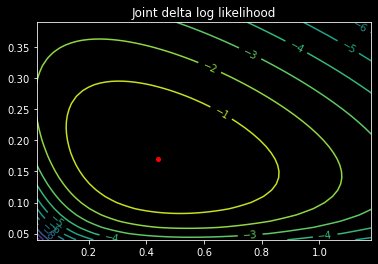

In [4]:
# Consider the following observed data:
# - with source inserted: 6 counts seen in 10 seconds
# - without source inserted: 5 counts seen in 30 seconds

observed = 6
observed_control = 5

# make model of control experiment (no source)

sim_control_detector = SimulatedRadiationCounter()
sim_control_detector.set_counting_time(30.)

# make model of experiment with source

simulated_source = RadioactiveSource(0.6) # specifies the activity of simulated source

sim_detector = SimulatedRadiationCounter()
sim_detector.set_counting_time(10)
sim_detector.insert_known_source(simulated_source)

# setup a mesh of values for the 2 parameters

a_vals = np.arange(0.02,1.2,0.02)
b_vals = np.arange(0.04,0.40,0.01)
a_mesh, b_mesh = np.meshgrid(a_vals,b_vals)

max_ll = -100
max_a = None
max_b = None
joint = []
for b in b_vals:
    row = []
    for a in a_vals:
        simulated_source.set_activity(a)
        sim_detector.set_background(b)
        sim_likelihood = sim_detector.get_likelihood(observed)
        
        sim_control_detector.set_background(b)
        sim_control_likelihood = sim_control_detector.get_likelihood(observed_control)
        
        # Calculate the joint log likelihood for the two parameters a and b:
        log_likelihood = np.log(sim_likelihood * sim_control_likelihood)
        
        row.append(log_likelihood)
        if log_likelihood > max_ll:
            max_ll = log_likelihood
            max_a = a
            max_b = b
            
    joint.append(row)

# set zero at the maximum
joint_offset = []
for row in joint:
    joint_offset.append(np.array(row)-max_ll)

print('Likelihood maximized at a=',round(max_a,2),' and b=',round(max_b,2))

#%%

fig, ax = plt.subplots()
CS = ax.contour(a_mesh, b_mesh, joint_offset, 12)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Joint delta log likelihood')

ax.plot([max_a],[max_b],marker='o',ms=4,color='red')
plt.show()

## Approximate 2D confidence interval

For a single parameter, an approximate 68% (90%) confidence interval is the set of parameters that yield a log likelihood within 0.5 (1.36) of the maximum.

For 2 parameters, an approximate 68% (90%) confidence interval is the region for which the parameters yield a log likelihood within 1.15 (2.31) of the maximum.

For this example, a broader range of activities are in the 90% confidence interval than in the case without background. 
The presence of background increases the uncertainty in the source activity.

## Rigorous 2D frequentist interval

While it is possible, it is challenging to implement a method that guarantees coverage. I recommend against doing so.

## Rigorous 1D frequentist interval

There are adhoc approaches to collapse the joint likelihood function to 1D (a function of $a$ alone). I recommend against these, and do a Bayesian analysis instead.